In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

In [91]:
df = pd.read_csv('frmgham2.csv')

In [92]:
df.head()

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766


In the previoius analysis of this data, we looked at some of the trends seen in the data and how some of the features relate to Death and cardiovascular events. 

In this notebook, we will be cleaning and normalisng the data in order to best prepare the data for a random forest model. 

In [93]:
df.columns

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE',
       'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ',
       'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD',
       'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD',
       'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'LDLC'),
  Text(1, 0, 'HDLC'),
  Text(2, 0, 'GLUCOSE'),
  Text(3, 0, 'BPMEDS'),
  Text(4, 0, 'TOTCHOL'),
  Text(5, 0, 'educ'),
  Text(6, 0, 'CIGPDAY'),
  Text(7, 0, 'BMI'),
  Text(8, 0, 'HEARTRTE')])

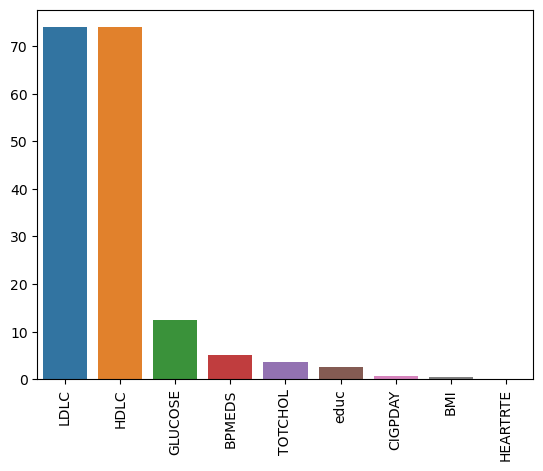

In [94]:
def percent_missing(df):
    total_values = len(df)
    missing_count = df.isnull().sum()
    percent_missing = (missing_count/total_values) * 100
    percent_missing.sort_values(ascending=False, inplace=True)
    return percent_missing[percent_missing > 0]

percent_missing_df = percent_missing(df)

sns.barplot(x = percent_missing_df.index, y = percent_missing_df)
plt.xticks(rotation=90)

From this plot we can see that LDLC and HDLC are missing > 70% of their data. We will therefore remove these columns from the dataset. 
Whilst glucose, BMI and SBP are missing < 30% of their data, we will keep these columns in the dataset as they are likely omitted because this data does not aplly to the patient (e.g. a patient with no diabetes will not have a glucose reading).

I am interested to see how many participants have missing values for each of the features with missing data.

In [95]:
percent_missing_df.index
for x in percent_missing_df.index:
    print(x + ": " + str(len(df[df[x].isnull()].groupby('RANDID'))))

LDLC: 4434
HDLC: 4434
GLUCOSE: 1253
BPMEDS: 580
TOTCHOL: 368
educ: 113
CIGPDAY: 78
BMI: 44
HEARTRTE: 6


For the missing data we could ideally inspect the data to see if the data was missing for all of the participant's visits, and then perhaps use an average of their other visits, such as using an average of their heart rates if they were fairly similar. However for the sake of time, I will only do this for the Heart Rate feature.

In [96]:
df[df['HEARTRTE'].isnull()].RANDID

1299     1080920
1434     1186959
1847     1557925
2630     2235925
3500     3029122
10250    8878837
Name: RANDID, dtype: int64

In [97]:
for x in df[df['HEARTRTE'].isnull()].RANDID:
    print(str(x) + ": " + str(df[df['RANDID'] == x].HEARTRTE.values))

1080920: [92. nan]
1186959: [85. nan]
1557925: [nan 80.]
2235925: [86. 80. nan]
3029122: [80. nan]
8878837: [75. 70. nan]


Looking at these values I think that the right thing to do here is to use the average of the other visits for the missing values. If there is only one visit, then we will just use the value for that visit.

In [98]:
df[df['HEARTRTE'].isnull()]

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
1299,1080920,2,193.0,70,168.0,70.0,0,0.0,NaN,1,...,1,1,2424,2424,1112,1112,1679,1112,2424,0
1434,1186959,2,NaN,73,200.0,100.0,1,2.0,36.53,0,...,0,1,5437,5437,5437,5437,5437,5437,5437,0
1847,1557925,1,219.0,64,172.5,75.0,1,18.0,29.29,0,...,1,1,2796,2794,2794,2794,2784,2784,2796,0
2630,2235925,2,NaN,77,202.5,95.5,0,0.0,NaN,0,...,0,1,4914,6763,6763,4914,6763,6763,6763,0
3500,3029122,2,238.0,71,124.0,80.0,1,NaN,NaN,0,...,0,0,6944,6944,6944,6944,6944,6944,6944,6944
10250,8878837,2,172.0,76,148.0,90.0,1,NaN,NaN,1,...,1,1,4936,4936,4936,4936,3410,3410,4936,0


In [99]:
df[df['HEARTRTE'].isnull()].index

Int64Index([1299, 1434, 1847, 2630, 3500, 10250], dtype='int64')

In [100]:
df[df.index == 1299]

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
1299,1080920,2,193.0,70,168.0,70.0,0,0.0,NaN,1,...,1,1,2424,2424,1112,1112,1679,1112,2424,0


In [101]:
for x in df[df['HEARTRTE'].isnull()].index:
    df.loc[x, 'HEARTRTE'] = df[df['RANDID'] == df.loc[x, 'RANDID']].HEARTRTE.mean()

In [102]:
df[df['HEARTRTE'].isnull()].index

Int64Index([], dtype='int64')

We can see now that those heart rates that were previoulsy missing have been filled in with the average of the other visits.

There are also 44 missing values for the BMI feature, lets have a quick look at these too.

In [103]:
arr = []
for x in df[df['BMI'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].BMI.values))

In [104]:
x = 0
for y in range(0,10):
    print(arr[y])

2448: [26.97   nan]
212271: [nan]
303367: [25.1    nan 25.75]
415724: [26.15   nan]
696867: [nan]
1019315: [25.13 25.68   nan]
1080920: [38.82   nan]
1269712: [20.49   nan]
1600765: [  nan 24.94 24.94]
2235925: [20.67 20.07   nan]


It looks like its going to be difficult for me to see what is going on just from the data, Im going to cheat a little and have a look at the groups with missing BMI values vs CVD and Death and compare that to those not missing BMI values.

In [105]:
total_CVD_missing =0
for z in df.BMI.isnull().index:
    total_CVD_missing += df.loc[z, 'CVD']

BMI_missing = total_CVD_missing / len(df.BMI.isnull())

total_CVD_not_missing =0
for z in df.BMI.notnull().index:
    total_CVD_not_missing += df.loc[z, 'CVD']

BMI_present = total_CVD_not_missing / len(df.BMI.notnull())

print ('CVD with BMI Missing ' + "= " + str(BMI_missing) + "\n " + 'CVD with BMI Present '+ "= " + str(BMI_present))

CVD with BMI Missing = 0.2493334480089447
 CVD with BMI Present = 0.2493334480089447


Looking at the results, it looks like the missing BMI values are fairly evenly distributed between those who have CVD and those who do not, thus I do not believe that these individuals with a missing BMI value have an increased or decreased risk of CVD or Death, according to this dataset. As before I am going to use the average of the other visits for the missing values.

In [106]:
for a in df[df.BMI.isnull()].index:
    df.loc[a, 'BMI'] = df[df['RANDID'] == df.loc[a, 'RANDID']].BMI.mean()

In [107]:
len(df[df['BMI'].isnull()])

22

In [108]:
arr = []
for x in df[df['BMI'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].BMI.values))


for v in arr:
    print(v)

212271: [nan]
696867: [nan]
2668575: [nan]
2687577: [nan]
3703116: [nan nan nan]
3703116: [nan nan nan]
3703116: [nan nan nan]
3762702: [nan nan]
3762702: [nan nan]
4067413: [nan nan]
4067413: [nan nan]
4648740: [nan]
4837467: [nan nan nan]
4837467: [nan nan nan]
4837467: [nan nan nan]
4899712: [nan]
5127790: [nan]
6921140: [nan nan nan]
6921140: [nan nan nan]
6921140: [nan nan nan]
7265381: [nan]
7834949: [nan]


It looks like there are 22 rows where there are no other BMI values for the participant, so I think I will have to drop these rows.

In [109]:
no_BMI_list = df[df['BMI'].isnull()].index

df.drop(axis=0, index=no_BMI_list, inplace=True)

Lets investigate the cigarette smoking feature.

In [110]:
print("Number of individuals missing smoking status = " + str(len(df[df.CIGPDAY.isnull()].groupby('RANDID').count().SEX)))

print("Number of rows missing smoking status = " + str(len(df[df.CIGPDAY.isnull()].index)))


Number of individuals missing smoking status = 78
Number of rows missing smoking status = 79


In [111]:
arr = []
for x in df[df['CIGPDAY'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].CIGPDAY.values))


for v in range(0,10):
    print(arr[v])

309808: [nan 40. 50.]
336991: [nan  0.  0.]
647094: [ 1.  0. nan]
769782: [ 0. nan]
962125: [25. nan  0.]
984588: [ 0. nan]
1049378: [50. 60. nan]
1294557: [ 5. nan]
1341461: [15. nan 20.]
1397567: [10. nan]


Again looking at the data I think that I will use the average of the other values for the missing values. 

In [112]:
for s in df[df['CIGPDAY'].isnull()].index:
    df.loc[s, 'CIGPDAY'] = df[df['RANDID'] == df.loc[s, 'RANDID']].CIGPDAY.mean()


In [113]:
arr = []
for x in df[df['CIGPDAY'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].CIGPDAY.values))


for v in arr:
    print(v)

2108588: [nan]


Looks like were just missing a single value for the CIGPDAY feature now, so I will just drop this row.

In [114]:
df.drop(axis=0, index = df[df['CIGPDAY'].isnull()].index, inplace=True)

The next feature that has missing values is the education feature, unless other vales are present for participants taken at different visits, I think that I will just drop these rows.

In [115]:
len(df[df['educ'].isnull()])

295

In [116]:
for s in df[df['educ'].isnull()].index:
    df.loc[s, 'educ'] = df[df['RANDID'] == df.loc[s, 'RANDID']].educ.mean()

In [117]:
len(df[df['educ'].isnull()])

295

Looks like none of the educ values are able to be filled by other visits, so I will just drop these rows.

In [118]:
df.drop(axis=0, index = df[df['educ'].isnull()].index, inplace=True)

The next thing on the list is the cholesterol feature, lets have a look at this.

In [119]:
len(df[df['TOTCHOL'].isnull()])

389

In [120]:
arr = []
for x in df[df['TOTCHOL'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].TOTCHOL.values))


for v in range(0,10):
    print(arr[v])

11252: [285. 343.  nan]
12806: [313.  nan 320.]
16799: [254.  nan 291.]
43522: [185. 270.  nan]
83398: [178. 155.  nan]
95148: [ nan 268. 240.]
97895: [252. 286.  nan]
125413: [250.  nan  nan]
125413: [250.  nan  nan]
206291: [274. 250.  nan]


Looks like there are sufficient values for the cholesterol feature to be able to fill in the missing values, so I will do this now.

In [121]:
for s in df[df['TOTCHOL'].isnull()].index:
    df.loc[s, 'TOTCHOL'] = df[df['RANDID'] == df.loc[s, 'RANDID']].TOTCHOL.mean()

In [122]:
arr = []
for x in df[df['TOTCHOL'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].TOTCHOL.values))


len(arr)

22

Looks like there are still 22 rows with missing values for the cholesterol feature, so I will drop these rows.

In [123]:
df.drop(axis=0, index=df[df['TOTCHOL'].isnull()].index, inplace=True)

Lets have a look at how much data we are missing now.

(array([0, 1, 2, 3]),
 [Text(0, 0, 'LDLC'),
  Text(1, 0, 'HDLC'),
  Text(2, 0, 'GLUCOSE'),
  Text(3, 0, 'BPMEDS')])

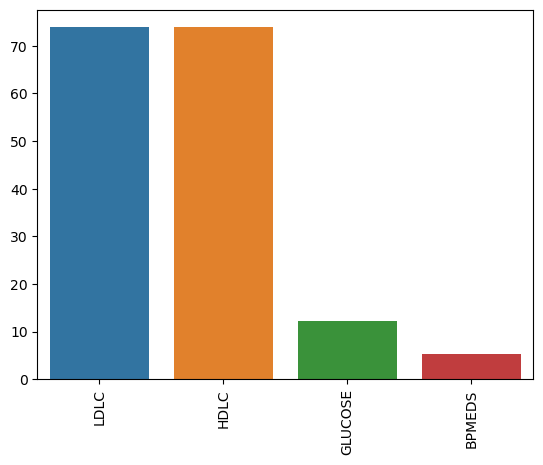

In [124]:
percent_missing_df = percent_missing(df)

sns.barplot(x = percent_missing_df.index, y = percent_missing_df)
plt.xticks(rotation=90)

Lets investigate the missing values for the BPMEDS feature.

In [125]:
len(df[df['BPMEDS'].isnull()])

585

Looks like there are 585 missing values, lets have a closer look at these.
Firstly lets see if these participants with missing BPMEDS are hypertensive.

<AxesSubplot: xlabel='HYPERTEN', ylabel='count'>

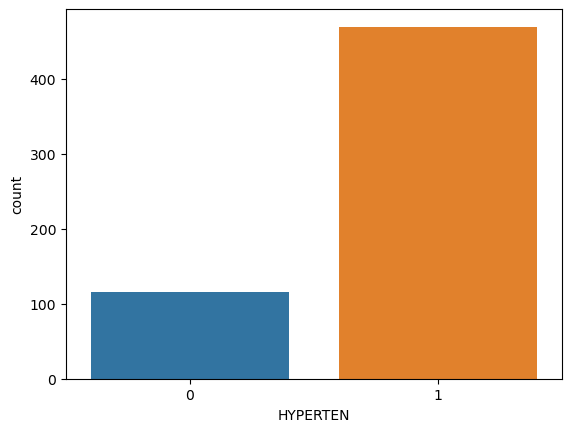

In [126]:
sns.countplot(x = df[df['BPMEDS'].isnull()].HYPERTEN)

Looking at this data, it looks like the majority of the participants with missing BPMEDS values are hypertensive.
Im unsure if these participants will be taking blood pressure medication or not, so I will try and see what the norm is in the rest of the dataset.

<AxesSubplot: xlabel='HYPERTEN', ylabel='count'>

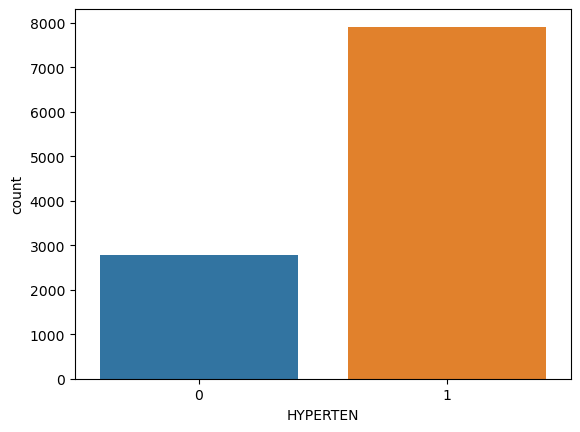

In [127]:
sns.countplot(x = df[df['BPMEDS'].notnull()].HYPERTEN)

Seems like there is a fairly even split between those taking blood pressure medication and those not taking blood pressure medication.
It seems unreasonable to assume that these participants are either taking or not taking their medication.
I will see if there are any values for other visits. 

In [128]:
arr = []
for x in df[df['BPMEDS'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].BPMEDS.values))


for v in range(0,10):
    print(arr[v])

16799: [ 0.  0. nan]
68397: [ 0. nan  0.]
77492: [ 0.  0. nan]
95148: [ 1.  1. nan]
97026: [ 0.  0. nan]
101990: [nan  0.  0.]
127109: [ 0.  0. nan]
149386: [ 0.  0. nan]
151110: [ 0.  0. nan]
162207: [ 0.  1. nan]


OK, seems like a fair few have BPMEDS status recorded during other visits, so I will fill in the missing values with either a 1 or a 0 depending on the other visits. If the patient has ever taken blood pressure medication, I will fill in the missing value with a 1, otherwise I will fill in the missing value with a 0.

In [133]:
def prev_BPMEDS(ind):
    if len(df[df['RANDID'] == df.loc[ind, 'RANDID']].BPMEDS) < 2:
        return np.nan
    sum = df[df['RANDID'] == df.loc[ind, 'RANDID']].BPMEDS.sum()
    if sum > 0:
        return 1
    else: return 0

In [134]:
for s in df[df['BPMEDS'].isnull()].index:
    df.loc[s, 'BPMEDS'] = prev_BPMEDS(s)

In [136]:
arr = []
for x in df[df['BPMEDS'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].BPMEDS.values))


for v in arr:
    print(v)

481202: [nan]
797308: [nan]
2286129: [nan]
4668307: [nan]
4669258: [nan]
4990326: [nan]
5524196: [nan]
7935008: [nan]


Looks like we're only missing a few values now, so I will just drop these rows.

In [137]:
df.drop(axis=0, index = df[df['BPMEDS'].isnull()].index, inplace=True)

Glucose is the next feature with missing values, lets have a look at this.

In [140]:
len(df[df['GLUCOSE'].isnull()])

1385

Looks like were missing quite a few values for the glucose feature, lets have a closer look at this.
Looking at other visits has served us well so far, so I will do this again.

In [142]:
arr = []
for x in df[df['GLUCOSE'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].GLUCOSE.values))


for v in range(0,10):
    print(arr[v])

11252: [85. 72. nan]
12806: [78. nan 87.]
24721: [nan 76. 97.]
33077: [72. nan 91.]
43522: [nan 85. nan]
43522: [nan 85. nan]
55965: [ nan  77. 100.]
77492: [87. 75. nan]
83398: [225. 200.  nan]
84815: [90. nan 80.]


It's very difficult to know whether these participants have a gradually increasing or decreasing glucose level.
It could be that these participants have a gradually increasing glucose level, and that the missing value could have been a high reading.
Or it could be that these participants have a gradually decreasing glucose level, and the missing value could have been a low reading.

If I had more time, I would try and investigate these trends further, but for now I will just fill in the missing values with the average of the other visits.

In [143]:
for s in df[df['GLUCOSE'].isnull()].index:
    df.loc[s, 'GLUCOSE'] = df[df['RANDID'] == df.loc[s, 'RANDID']].GLUCOSE.mean()

In [145]:
arr = []
for x in df[df['GLUCOSE'].isnull()].RANDID:
    arr.append(str(x) + ": " + str(df[df['RANDID'] == x].GLUCOSE.values))


len(arr)

89

looks like there are still 89 rows with missing values for the glucose feature, so I will drop these rows.

In [146]:
df.drop(axis=0, index=df[df['GLUCOSE'].isnull()].index, inplace=True)

Now I have covered all of the features with missing values, up to 20%. 
I will now remove HDL and LDL features from the dataset as they were missing > 70% of their data, and so would be filled in based off of assumptions that I would be uncomfortable making.

In [148]:
df.drop(axis = 1, columns=['HDLC', 'LDLC'], inplace = True)

In [152]:
df.to_csv('frmgham_clean.csv')

I have now filled in all of the missing values in the dataset I thought that I could fill. I have also dropped and rows or columns that I felt were not able to be completed, for reasons that I explained above.

The next step in the data cleaning process is to normalise the data.